In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.datasets import support

from pycox.models import LogisticHazard
from pycox.models import CoxPH
from pycox.models import PCHazard
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv


In [2]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(678)
_ = torch.manual_seed(678)

# Load Data and Pre-Processing

In [3]:
df = support.read_df()
df_train = support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [5]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# DeepSurv

In [6]:
# Processing labels
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [12]:
# Build Models
in_features = x_train.shape[1]
num_nodes = [32, 32, 32]
out_features = 1
batch_norm = True
dropout = 0.2
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)


In [13]:
# Train the model
batch_size = 256
epochs = 100
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)

model.optimizer.set_lr(lrfinder.get_best_lr())
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 5.6275,	val_loss: 4.9856
1:	[0s / 0s],		train_loss: 5.3758,	val_loss: 4.9367
2:	[0s / 0s],		train_loss: 5.4124,	val_loss: 4.9274
3:	[0s / 0s],		train_loss: 5.1850,	val_loss: 4.9726
4:	[0s / 0s],		train_loss: 5.1859,	val_loss: 4.9634
5:	[0s / 0s],		train_loss: 5.3626,	val_loss: 4.9266
6:	[0s / 0s],		train_loss: 5.3169,	val_loss: 4.9306
7:	[0s / 0s],		train_loss: 5.2327,	val_loss: 4.9327
8:	[0s / 0s],		train_loss: 5.2820,	val_loss: 4.9329
9:	[0s / 1s],		train_loss: 5.1202,	val_loss: 4.9201
10:	[0s / 1s],		train_loss: 5.2385,	val_loss: 4.9119
11:	[0s / 1s],		train_loss: 5.0969,	val_loss: 4.9144
12:	[0s / 1s],		train_loss: 5.0701,	val_loss: 4.9193
13:	[0s / 1s],		train_loss: 5.3411,	val_loss: 4.9126
14:	[0s / 1s],		train_loss: 5.0746,	val_loss: 4.9159
15:	[0s / 1s],		train_loss: 5.0736,	val_loss: 4.9145
16:	[0s / 1s],		train_loss: 5.0268,	val_loss: 4.9162
17:	[0s / 1s],		train_loss: 5.0911,	val_loss: 4.9123
18:	[0s / 1s],		train_loss: 5.0782,	val_loss: 4.9124
19:

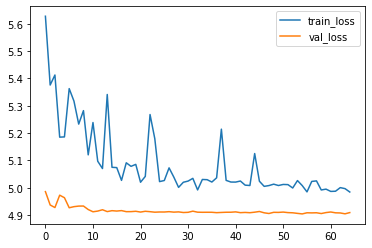

In [14]:
_ = log.plot()


In [15]:
# Evaluate the model
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw, brier_score

def eval_single(df_train_all, model, test_set, val_batch_size=None):
    get_target = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    
    horizons = [0.25, 0.5, 0.75]
    times = np.quantile(df["duration"][df["event"]==1.0], horizons).tolist()
    

    df_test, df_y_test = test_set
    _ = model.compute_baseline_hazards()
    surv = model.predict_surv(df_test, batch_size=val_batch_size)
    risk = 1 - surv

    durations_test, events_test = get_target(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    metric_dict = defaultdict(list)

    cis = []
    for i, _ in enumerate(times):
        cis.append(
            concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
            )
        metric_dict[f'{horizons[i]}_ipcw'] = cis[i]
#         metric_dict[f'{horizons[i]}_brier'] = brs[i]


    for horizon in enumerate(horizons):
        print(f"For {horizon[1]} quantile,")
        print("TD Concordance Index - IPCW:", cis[horizon[0]])

    return metric_dict

In [16]:
df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.5400971167512248
For 0.5 quantile,
TD Concordance Index - IPCW: 0.5145437787590486
For 0.75 quantile,
TD Concordance Index - IPCW: 0.5130080692171102


defaultdict(list,
            {'0.25_ipcw': 0.5400971167512248,
             '0.5_ipcw': 0.5145437787590486,
             '0.75_ipcw': 0.5130080692171102})

# DeepHit

In [17]:
# Processing Labels
labtrans = DeepHitSingle.label_transform(cuts=20)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [18]:
# Build the model and train
in_features = x_train.shape[1]
num_nodes = [32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam(0.001), duration_index=labtrans.cuts)


In [19]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 0.7775,	val_loss: 0.7147
1:	[0s / 0s],		train_loss: 0.7573,	val_loss: 0.7096
2:	[0s / 0s],		train_loss: 0.7479,	val_loss: 0.7041
3:	[0s / 0s],		train_loss: 0.7351,	val_loss: 0.6981
4:	[0s / 0s],		train_loss: 0.7253,	val_loss: 0.6931
5:	[0s / 0s],		train_loss: 0.7195,	val_loss: 0.6883
6:	[0s / 1s],		train_loss: 0.7106,	val_loss: 0.6809
7:	[0s / 1s],		train_loss: 0.7018,	val_loss: 0.6759
8:	[0s / 1s],		train_loss: 0.7016,	val_loss: 0.6694
9:	[0s / 1s],		train_loss: 0.6939,	val_loss: 0.6641
10:	[0s / 1s],		train_loss: 0.6832,	val_loss: 0.6618
11:	[0s / 1s],		train_loss: 0.6825,	val_loss: 0.6560
12:	[0s / 1s],		train_loss: 0.6775,	val_loss: 0.6517
13:	[0s / 2s],		train_loss: 0.6690,	val_loss: 0.6501
14:	[0s / 2s],		train_loss: 0.6685,	val_loss: 0.6474
15:	[0s / 2s],		train_loss: 0.6646,	val_loss: 0.6396
16:	[0s / 2s],		train_loss: 0.6613,	val_loss: 0.6406
17:	[0s / 2s],		train_loss: 0.6522,	val_loss: 0.6321
18:	[0s / 2s],		train_loss: 0.6523,	val_loss: 0.6295
19:

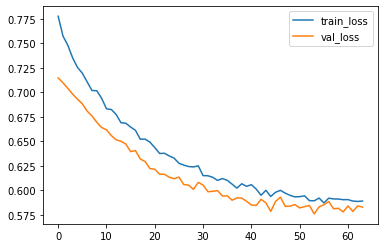

In [20]:
_ = log.plot()


In [21]:
# Evaluate the model

def eval_single(df_train_all, model, test_set, val_batch_size=None):
    get_target = lambda df: (df['duration'].values, df['event'].values)
    durations_train, events_train = get_target(df_train_all)
    et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                    dtype = [('e', bool), ('t', float)])
    
    horizons = [0.25, 0.5, 0.75]
    times = np.quantile(df["duration"][df["event"]==1.0], horizons).tolist()
    

    df_test, df_y_test = test_set
    surv = model.predict_surv(df_test, batch_size=val_batch_size)
    risk = 1 - surv

    durations_test, events_test = get_target(df_y_test)
    et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                dtype = [('e', bool), ('t', float)])

    metric_dict = defaultdict(list)

    cis = []
    for i, _ in enumerate(times):
        cis.append(
            concordance_index_ipcw(et_train, et_test, estimate=risk[:, i+1], tau=times[i])[0]
            )
        metric_dict[f'{horizons[i]}_ipcw'] = cis[i]

    for horizon in enumerate(horizons):
        print(f"For {horizon[1]} quantile,")
        print("TD Concordance Index - IPCW:", cis[horizon[0]])

    return metric_dict

df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.5929454322261327
For 0.5 quantile,
TD Concordance Index - IPCW: 0.54856477547628
For 0.75 quantile,
TD Concordance Index - IPCW: 0.5561711888657758


defaultdict(list,
            {'0.25_ipcw': 0.5929454322261327,
             '0.5_ipcw': 0.54856477547628,
             '0.75_ipcw': 0.5561711888657758})

# PC-Hazard 

In [22]:
# Processing labels
num_durations = 10
labtrans = PCHazard.label_transform(cuts=num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [23]:
# Build the model and train
in_features = x_train.shape[1]
num_nodes = [32, 32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.2

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)



In [19]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 1.9736,	val_loss: 1.8713
1:	[0s / 0s],		train_loss: 1.8872,	val_loss: 1.7815
2:	[0s / 0s],		train_loss: 1.8283,	val_loss: 1.7254
3:	[0s / 0s],		train_loss: 1.7647,	val_loss: 1.6649
4:	[0s / 0s],		train_loss: 1.7161,	val_loss: 1.5923
5:	[0s / 0s],		train_loss: 1.6416,	val_loss: 1.5181
6:	[0s / 0s],		train_loss: 1.5641,	val_loss: 1.4329
7:	[0s / 0s],		train_loss: 1.5032,	val_loss: 1.4013
8:	[0s / 1s],		train_loss: 1.4465,	val_loss: 1.3431
9:	[0s / 1s],		train_loss: 1.3908,	val_loss: 1.3160
10:	[0s / 1s],		train_loss: 1.3291,	val_loss: 1.2802
11:	[0s / 1s],		train_loss: 1.3108,	val_loss: 1.2453
12:	[0s / 1s],		train_loss: 1.2905,	val_loss: 1.2302
13:	[0s / 1s],		train_loss: 1.2499,	val_loss: 1.2187
14:	[0s / 1s],		train_loss: 1.2324,	val_loss: 1.2160
15:	[0s / 2s],		train_loss: 1.2203,	val_loss: 1.2097
16:	[0s / 2s],		train_loss: 1.2113,	val_loss: 1.2064
17:	[0s / 2s],		train_loss: 1.2144,	val_loss: 1.2048
18:	[0s / 2s],		train_loss: 1.1912,	val_loss: 1.2060
19:

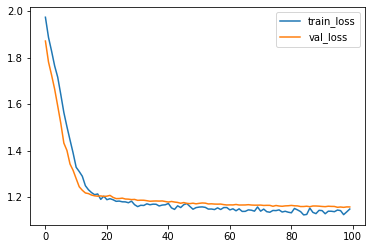

In [20]:
_ = log.plot()


In [21]:
df_y_test = pd.DataFrame({"duration": df['duration'].loc[df_test.index], "event": df['event'].loc[df_test.index]})
eval_single(df_train, model, (x_test, df_y_test))

For 0.25 quantile,
TD Concordance Index - IPCW: 0.6228178266188975
For 0.5 quantile,
TD Concordance Index - IPCW: 0.6013140031031807
For 0.75 quantile,
TD Concordance Index - IPCW: 0.6082745032272636


defaultdict(list,
            {'0.25_ipcw': 0.6228178266188975,
             '0.5_ipcw': 0.6013140031031807,
             '0.75_ipcw': 0.6082745032272636})